## Multiple features
In the previous example we had a single input variable (feature) - the `years of experience`. 

However, it turns out the `salary` is not only a matter of `years of experience`, but also a matter of `education level`. So, in order to represent more closely the real-world logic for picking a `salary` we should introduce an extra dimension (extra feature) in our input data.

The `education level` will be represented by a number:
* `0 - High school`
* `1 - College`
* `2 - Bachelor`
* `3 - Bachelor (in DS/ML/AI)`
* `4 - Master`
* `5 - Master (in DS/ML/AI)`
* `6 - PhD`
* `7 - PhD (in DS/ML/AI)`

In [77]:
# X1 = years of experience
X1 = [1.2, 1.3, 1.5, 1.8, 2, 2.1, 2.2, 2.5, 2.8, 2.9, 3.1, 3.3, 3.5, 3.8, 4, 4.1, 4.5, 4.9, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 10, 11, 12, 13, 14, 15]
# X2 = level of education
X2 = [2, 5, 3, 5, 3, 4, 2, 3, 4, 4, 3, 7, 5, 6, 5, 5, 2, 3, 4, 5, 6, 7, 5, 3, 2, 4, 5, 7, 3, 5, 7, 7, 5]
# Y = salary
Y = [2900, 3300, 3100, 4200, 3500, 3800, 3300, 3500, 3750, 4000, 3900, 5300, 4420, 5000, 4900, 5200, 3900, 4800, 5700, 6500, 6930, 7500, 7360, 6970, 6800, 7500, 8000, 9500, 11000, 9500, 12300, 13700, 12500]

In the ML world instead of simple arrays it is common to use data frames.

In [78]:
import copy
import math
import pandas as pd             # Pandas is a library for using data frames
import numpy as np              # Numpy is a library for numerical computing
import matplotlib.pyplot as plt # Matplotlib is a library for creating static, animated, and interactive visualizations

In [79]:
# Pandas data frame works with vectorized arrays (33 arrays of 1 element each)
vectorized_X1 = np.array(X1).reshape(-1, 1)
vectorized_X2 = np.array(X2).reshape(-1, 1)
vectorized_Y = np.array(Y).reshape(-1, 1)

print(vectorized_X1.shape)

# Build the data frame
merged_vectors = np.concatenate([vectorized_X1, vectorized_X2, vectorized_Y], axis=1)
data = pd.DataFrame(merged_vectors, columns=['Years of experience', 'Level of education', 'Salary'])  

# Display the first few rows of the data frame
data.head()

(33, 1)


,Years of experience,Level of education,Salary
0,1.2,2.0,2900.0
1,1.3,5.0,3300.0
2,1.5,3.0,3100.0
3,1.8,5.0,4200.0
4,2.0,3.0,3500.0


In [80]:
# Display the summary statistics of the data frame
data.describe()

,Years of experience,Level of education,Salary
count,33.000000,33.000000,33.000000
mean,5.742424,4.424242,6197.878788
std,3.918867,1.581738,2962.854153
min,1.200000,2.000000,2900.000000
25%,2.800000,3.000000,3900.000000
50%,4.500000,5.000000,5200.000000
75%,8.000000,5.000000,7500.000000
max,15.000000,7.000000,13700.000000


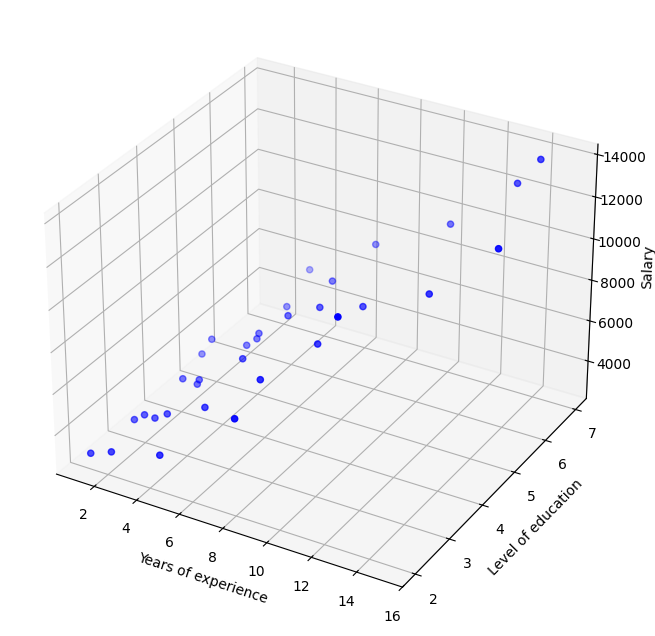

In [81]:
# Make 3D scatter plot - let's see how the salary is affected by the years of experience and the level of education
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='blue', marker='o')
ax.set_xlabel('Years of experience')
ax.set_ylabel('Level of education')
ax.set_zlabel('Salary')
plt.show()

## Dot product
In our previous example the linear function that was expected to represent the data points looked like this:
$$ y = b + wx $$
where $x$ was the input feature (`years of experience`) and $w$ was the weight coefficient (*importance*) of that feature for the output result $y$. And the output result $y$ was simply the corresponding `salary`.

Now, we have two input features $x_1$ and $x_2$ which represents the `years of experience` and `education level`. So the linear polynomial function which is expected to represent the data points looks like this:
$$ y = b + w_1x_1 + w_2x_2$$

In [82]:
def compute_y(x: np.ndarray, w: np.ndarray, b: float) -> float:
    """Calculates the predicted value of y for given x values, w (weights), and b (bias)."""
    y = b
    for i in range(len(x)):
        y += w[i]*x[i]
    return y

For the sake of **performance** instead of looping through all $x_i$ features, we can simply perform **dot product** operation between two vectors with same size.

$$ y = b + \vec w \cdot \vec x $$

In [83]:
def compute_y(x: np.ndarray, w: np.ndarray, b: float) -> float:
  """Calculates the predicted value of y for a given x (observation vector), w (weights), and b (bias)."""
  return b + np.dot(w, x)

The GPU can handle this as a **single** operation, rather than executing a loop with multiple microoperations that a CPU will execute if being used instead.

The previous implementation of `compute_cost()` should also be revised.

In [84]:
def compute_cost(X: np.ndarray, Y: np.ndarray, w: float, b: float) -> float:
    m = len(X)
    cost = 0
    for i in range(m):
        y_predict = compute_y(X[i], w, b)
        cost += (y_predict - Y[i]) ** 2
    return cost / m

The new version will use **DataFrame** instead of **array**.

In [85]:
def compute_cost(X: pd.DataFrame, Y: np.ndarray, w: np.ndarray, b: float) -> float:
  """Calculates the error (cost) for a given X (set of vectors), Y (target values), w (weights), and b (bias).""" 
  m = X.shape[0]        # The number of examples (rows) in the training set
  cost = 0.
  X = X.values.tolist() # Conversion to lists is required to avoid issues with missing indices in the training set.
  Y = Y.tolist()        # Conversion to lists is required to avoid issues with missing indices in the training set.

  for i in range(m):
    cost += (compute_y(X[i], w, b) - Y[i]) ** 2
  return cost / m

Adn finally, an extra loop in the `compute_gradient()` function is needed.

In [86]:
def compute_gradient(X: pd.DataFrame, Y: np.ndarray, w: np.ndarray, b: float) -> tuple[np.ndarray, float]: 
    """
    Computes the gradient for linear regression with multiple features
    Args:
      X (ndarray (m,n)): Data, m rows with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape               # (number of rows, number of features)
    X = X.values.tolist()       # Conversion to lists is required to avoid issues with missing indices in the training set.
    Y = Y.tolist()              # Conversion to lists is required to avoid issues with missing indices in the training set.
    dj_dw = np.zeros((n,))      # Now we return not a single weight, but a list of weights.
    dj_db = 0.

    for i in range(m):
        y_pred = compute_y(X[i], w, b)
        err = y_pred - Y[i]
        # Extra loop: we have `n` features (w1, w2, ... wn) - we assess how strongly each of them affects the error (cost).
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i][j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m   # We divide all the weight derivatives by `m` (the number of rows)
    dj_db = dj_db / m   # We divide the bias derivative by `m` (the number of rows)

    return dj_db, dj_dw

Minor updates would be needed in the `gradient_descent()` function as well.

In [87]:
def gradient_descent(X: pd.DataFrame, y: np.ndarray, w_in: np.ndarray, b_in: np.ndarray, alpha: float, num_iters: int) -> tuple[np.ndarray, float, list]: 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    J_history = []            # An array to store cost J and w's at each iteration primarily for graphing later
    w = copy.deepcopy(w_in)   # Avoid modifying global `w_in within current function
    b = b_in                  # Avoid modifying global `b_in within current function

    for i in range(num_iters):
        # Calculate the gradient for these `w` and `b`
        dj_db, dj_dw = compute_gradient(X, y, w, b)

        # Update `w` and `b` based on the gradient (up or down) and the specified learning rate
        w = w - alpha * dj_dw   # vector operation (w and dj_dw are vectors with the same size)
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost(X, y, w, b) )

        # Print the cost after every 10% of the iterations
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")

    return w, b, J_history # return final w,b and J history for graphing

And now, let's test the multiple-featured gradient descent.

In [88]:
# Prepare the data
X = data.drop(['Salary'],axis=1)
Y = data['Salary']

# Configure gradient descent settings
b_init = 2000
w_init = np.array([800, 0])
alpha = 0.01
iterations = 5000

# Execute the gradient descent in search for optimal cost function (optimal `w` and `b`)
w, b, J_history = gradient_descent(X, Y, w_init, b_init, alpha, iterations)
print(f"Final b is {b} and w are {w}")

Iteration    0: Cost 467409.38   
Iteration  500: Cost 290475.02   
Iteration 1000: Cost 262791.54   
Iteration 1500: Cost 253081.11   
Iteration 2000: Cost 249675.03   
Iteration 2500: Cost 248480.29   
Iteration 3000: Cost 248061.22   
Iteration 3500: Cost 247914.22   
Iteration 4000: Cost 247862.66   
Iteration 4500: Cost 247844.57   
Final b is 961.1117182775961 and w are [691.29727634 286.52002784]


Now the best cost we achieve is $247844$ which is significantly lower than the single-featured descent result, which was $417053$. In other words our new model is more accurate than the previous one.

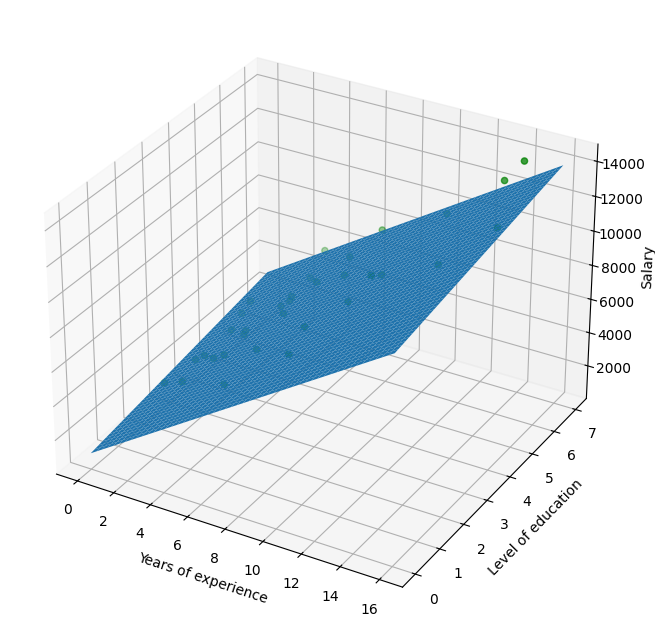

In [94]:
# Scatter the initial data points.
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, c='green', marker='o')
ax.set_xlabel('Years of experience')
ax.set_ylabel('Level of education')
ax.set_zlabel('Salary')

# Plot the linear function (it is a surface now), using the weights from the model.
yrs = np.linspace(0, 16, 1000)
ed_level = np.linspace(0, 7, 1000)
yrs, ed_level = np.meshgrid(yrs, ed_level)
predicted_salary = np.array([b + w[0]*x1 + w[1]*x2 for x1, x2 in zip(np.ravel(yrs), np.ravel(ed_level))])
predicted_salary = predicted_salary.reshape(yrs.shape)
ax.plot_surface(yrs, ed_level, predicted_salary)
plt.show()